In [26]:
print("Friends Data Sentiment Analysis Base On CNN")

Friends Data Sentiment Analysis Base On CNN


In [27]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"minkikwak","key":"8bbf6c259863c84c9ce8ada021aa02a6"}'}

In [28]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [29]:
!git clone https://github.com/dolphz/2020-2nd-NLP
!tar -xvf /content/2020-2nd-NLP/EmotionLines_friends_annotation.tar.gz

fatal: destination path '2020-2nd-NLP' already exists and is not an empty directory.
EmotionLines/Friends/friends_train.json
EmotionLines/Friends/friends_dev.json
EmotionLines/Friends/friends_test.json
EmotionLines/README


In [11]:
#라이브러리 호출
import json
import re
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from keras.utils import np_utils
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

#불용어 정의
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
stemmer = nltk.stem.SnowballStemmer('english')
print(stopwords)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{"it's", 'am', 'myself', 'him', 'doing', 'my', 'to', 'yours', 'of', 'through', 're', "needn't", 'further', 'have', 'when', "couldn't", "you'd", 'for', 've', 'we', 'but', "mightn't", 'he', 'has', 'why', 'd', 'his', 'some', 'and', 'ourselves', 'nor', 'by', 'ain', 'while', 'yourselves', 'll', "wasn't", 'just', 'mightn', 'between', 'into', 'she', 'himself', 'or', 'themselves', 'up', 'were', "mustn't", 'here', 'not', 'y', 'hers', "shan't", 'in', 's', 'such', 'where', 'weren', 'won', 'too', "wouldn't", 'theirs', 'so', "won't", 'i', 'whom', 'hadn', 'being', "weren't", 'down', 'very'

In [5]:
#Json File을 읽어 들인 후 필요한 부분만 파싱하는 함수
def readData(dataset_type):
  with open('/content/EmotionLines/Friends/%s.json' % dataset_type, "r", encoding="utf-8") as json_file:
    json_data = json.load(json_file)

  emotions, utterances = [], []
  max_seq_len = 0

  for i in range(0, len(json_data), 1):
    for j in range(0, len(json_data[i]), 1):
      emotions.append(mapper(json_data[i][j]["emotion"]))
      utterance = preProcessing(json_data[i][j]["utterance"])    #전처리 함수 호출
      max_seq_len = max(max_seq_len, len(utterance))             #Max Length 구하기
      utterances.append(utterance)
      utterances, emotions = delNulls(utterances, emotions)
  return emotions, utterances, max_seq_len

#감정 값을 숫자로 맵핑
def mapper(data):
  result = 0
  if data == 'neutral':
    result = 0
  elif data == 'surprise':
    result = 1
  elif data == 'fear':
    result = 2
  elif data == 'non-neutral':
    result = 3
  elif data == 'joy':
    result = 4
  elif data == 'sadness':
    result = 5
  elif data == 'anger':
    result = 6
  else:
    result = 7
  return result

#전처리 함수
#https://www.secmem.org/blog/2020/07/19/Sentiment-Analysis/
def preProcessing(data):
  before = data
  symbol_deleted = re.sub('[^a-zA-Z]', ' ', before)                   #특수문자 제거
  lowered = symbol_deleted.lower().split()                            #소문자 化
  sw_deleted = [word for word in lowered if not word in stopwords]    #불용어 제거
  stemmed = [stemmer.stem(word) for word in sw_deleted]               #어간 추출
  return ' '.join(stemmed)

#Null Data 제거
def delNulls(list1, list2):
  #list1은 Utterance, list2는 Emotion 값을 의미
  newList1, newList2 = [], []
  for i in range(0, len(list1), 1):
    if len(list1[i]) != 0:
      newList1.append(list1[i])
      newList2.append(list2[i])
  return newList1, newList2

myTrainLabel, myTrainSet, myTrainMaxLen = readData("friends_train")
myTestLabel, myTestSet, myTestMaxLen = readData("friends_test")
myDevLabel, myDevSet, myDevMaxLen = readData("friends_dev")
max_len = max(myTrainMaxLen, myTestMaxLen, myDevMaxLen) #Train과 Test 전체에서 가장 긴 길이

print("TrainSet : ", len(myTrainSet))
print("TrainLabel : ", len(myTrainLabel))
for i in range(0, 10, 1):
  print(myTrainLabel[i], ":", myTrainSet[i])

print("TestSet : ", len(myTestSet))
print("TestLabel : ", len(myTestLabel))
for i in range(0, 10, 1):
  print(myTestLabel[i], ":", myTestSet[i])

print("DevSet : ", len(myDevSet))
print("DevLabel : ", len(myDevLabel))
for i in range(0, 10, 1):
  print(myDevLabel[i], ":", myDevSet[i])

TrainSet :  10011
TrainLabel :  10011
0 : also point person compani transit kl gr system
0 : must hand full
0 : let talk littl bit duti
1 : duti right
0 : head whole divis lot duti
0 : see
0 : perhap peopl dump certain amount
0 : good know
0 : go detail
2 : beg
TestSet :  2626
TestLabel :  2626
1 : coffe mug number bottom
3 : oh monica keep track way one miss like number
0 : know
4 : okay use rachel got alic
1 : wh like
4 : cool man caus much better like
0 : yeah yeah
3 : find
6 : ask blew
3 : well want
DevSet :  1108
DevLabel :  1108
3 : oh god lost total lost
0 : could go bank close account cut sourc
4 : genius
5 : aww man bank buddi
0 : two reason
0 : hey
4 : hey
0 : ohh guy rememb cute client told bit
0 : touchi
1 : know


In [6]:
print(myTrainSet)

['also point person compani transit kl gr system', 'must hand full', 'let talk littl bit duti', 'duti right', 'head whole divis lot duti', 'see', 'perhap peopl dump certain amount', 'good know', 'go detail', 'beg', 'right definit answer monday think say confid fit well', 'realli', 'absolut relax great', 'waitress went last month', 'know forget', 'talk', 'actual know', 'ok', 'right well', 'gonna see get room night', 'see later', 'yeah sure', 'hey mon', 'hey hey hey wanna hear someth suck', 'ever', 'chris say close bar', 'way', 'yeah appar turn kinda coffe place', 'coffe gonna hang', 'got', 'get beer', 'hey pick roommat', 'betcha', 'italian guy', 'um mm yeah right', 'oh god oh god poor monica', 'wrote poem', 'look vessel empti noth insid', 'touch seem emptier still', 'think monica empti empti vase', 'realli think meant', 'oh total oh god oh seem happi', 'done', 'hey', 'hi', 'ah know build paper rout', 'oh', 'hi', 'hi', 'go', 'oh well woman interview pretti tough know thank god mark coach

In [7]:
#데이터 로드 및 파싱 과정이 오래 소요 되어 Call-By-Value 원리 사용
TrainSet = myTrainSet
TestSet = myTestSet
DevSet = myDevSet
TrainLabel = myTrainLabel
TestLabel = myTestLabel
DevLabel = myDevLabel

#One-Hot 인코딩
print(TrainLabel)
TrainLabel = np_utils.to_categorical(myTrainLabel)
TestLabel = np_utils.to_categorical(myTestLabel)
DevLabel = np_utils.to_categorical(myDevLabel)
print(TrainLabel)

[0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 3, 1, 3, 0, 0, 3, 3, 0, 0, 0, 4, 5, 1, 0, 3, 5, 0, 0, 4, 0, 3, 1, 0, 0, 0, 1, 3, 5, 0, 3, 3, 0, 0, 0, 0, 0, 4, 4, 3, 0, 0, 0, 0, 0, 0, 1, 4, 1, 4, 0, 0, 3, 3, 0, 3, 6, 6, 3, 0, 0, 5, 5, 5, 1, 3, 3, 6, 3, 0, 3, 0, 0, 0, 0, 4, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 7, 3, 6, 6, 3, 6, 6, 0, 3, 0, 4, 0, 0, 4, 4, 4, 4, 3, 4, 3, 3, 0, 2, 0, 1, 2, 3, 6, 4, 0, 1, 0, 0, 0, 0, 1, 0, 0, 6, 0, 0, 5, 1, 5, 3, 5, 0, 5, 0, 0, 0, 0, 0, 3, 6, 6, 6, 3, 3, 4, 4, 4, 4, 3, 1, 0, 0, 6, 4, 0, 0, 2, 0, 2, 4, 4, 4, 4, 0, 0, 0, 4, 0, 4, 2, 3, 1, 2, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 4, 3, 1, 0, 0, 3, 1, 0, 1, 6, 7, 0, 0, 7, 0, 4, 7, 0, 1, 0, 1, 3, 1, 3, 0, 0, 0, 0, 1, 0, 0, 0, 4, 1, 0, 0, 4, 2, 4, 4, 4, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 1, 0, 0, 4, 4, 4, 0, 0, 0, 3, 0, 0, 3, 4, 3, 3, 3, 4, 2, 4, 2, 3, 1, 3, 0, 4, 3, 6, 6, 3, 6, 3, 3, 0, 0, 4, 0, 0, 6, 1, 6, 2, 0, 0, 2, 0, 6, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 4, 4, 3, 3, 3, 0, 0, 2, 0, 3, 4, 0, 0, 1, 0, 0, 0, 

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(TrainSet)

#vocab_size 계산
print(tokenizer.word_index)
vocab_size = len(tokenizer.word_index)
print(vocab_size)

tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(TrainSet)

#Review Data를 Sequence Data로 Converting
TrainSet = tokenizer.texts_to_sequences(TrainSet)
TestSet = tokenizer.texts_to_sequences(TestSet)
DevSet = tokenizer.texts_to_sequences(DevSet)

print(TrainSet[:10])
print(TestSet[:10])
print(TrainLabel[:10])

print(TrainSet[0], ":", TrainLabel[0])

print(len(TrainSet))
print(len(TrainLabel))
print(len(TestSet))
print(len(TestLabel))

{'oh': 1, 'know': 2, 'okay': 3, 'yeah': 4, 'hey': 5, 'well': 6, 'go': 7, 'right': 8, 'get': 9, 'like': 10, 'gonna': 11, 'look': 12, 'think': 13, 'uh': 14, 'realli': 15, 'guy': 16, 'want': 17, 'one': 18, 'come': 19, 'mean': 20, 'see': 21, 'got': 22, 'god': 23, 'ross': 24, 'tell': 25, 'good': 26, 'sorri': 27, 'joey': 28, 'thank': 29, 'say': 30, 'let': 31, 'great': 32, 'hi': 33, 'yes': 34, 'would': 35, 'time': 36, 'thing': 37, 'love': 38, 'umm': 39, 'could': 40, 'back': 41, 'make': 42, 'chandler': 43, 'littl': 44, 'wait': 45, 'someth': 46, 'monica': 47, 'phoeb': 48, 'talk': 49, 'rachel': 50, 'take': 51, 'huh': 52, 'ok': 53, 'wanna': 54, 'call': 55, 'said': 56, 'us': 57, 'need': 58, 'pleas': 59, 'happen': 60, 'peopl': 61, 'ah': 62, 'never': 63, 'feel': 64, 'sure': 65, 'work': 66, 'man': 67, 'mayb': 68, 'listen': 69, 'give': 70, 'much': 71, 'way': 72, 'friend': 73, 'actual': 74, 'still': 75, 'um': 76, 'wow': 77, 'two': 78, 'marri': 79, 'fine': 80, 'believ': 81, 'even': 82, 'first': 83, 'tho

리뷰의 최대 길이 : 33
리뷰의 평균 길이 : 3.9336729597442814


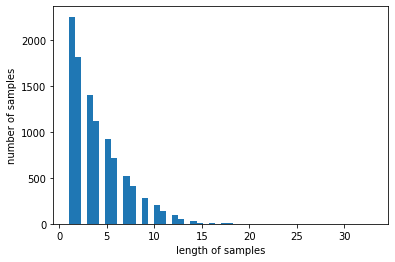

> Length가 10 이하인 데이터의 비율 : 96.54380181800019
> Length가 15 이하인 데이터의 비율 : 99.76026370991909
> Length가 20 이하인 데이터의 비율 : 99.96004395165318
> Length가 30 이하인 데이터의 비율 : 99.9900109879133
> Length가 35 이하인 데이터의 비율 : 100.0


In [9]:
import matplotlib.pyplot as plt

print('리뷰의 최대 길이 :',max(len(l) for l in TrainSet))
print('리뷰의 평균 길이 :',sum(map(len, TrainSet))/len(TrainSet))
plt.hist([len(s) for s in TrainSet], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

def calculateRatio(max_len, dataset):
  count = 0
  for data in dataset:
    if(len(data) <= max_len):
        count = count + 1
  print('> Length가', max_len, '이하인 데이터의 비율 : %s' % (count / len(dataset)*100))

calculateRatio(10, TrainSet)
calculateRatio(15, TrainSet)
calculateRatio(20, TrainSet)
calculateRatio(30, TrainSet)
calculateRatio(35, TrainSet)

max_len = 30

In [10]:
TrainSet = pad_sequences(TrainSet, padding='post', maxlen = max_len)
TestSet = pad_sequences(TestSet, padding='post', maxlen = max_len)
DevSet = pad_sequences(DevSet, padding='post', maxlen = max_len)

print("현재 Padding Size는", max_len, "입니다")
print(TrainSet[:2])
print(TestSet[:2])

print(len(TrainSet))
print(len(TrainLabel))
print(len(TestSet))
print(len(TestLabel))

현재 Padding Size는 30 입니다
[[ 287  455  224  794 1603 2217 2218  708    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 239  158  644    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
[[ 225  273 1182    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   1   47  165 3053   72   18  233   10  273    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
10011
10011
2626
2626


In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.layers import Embedding, Dense, MaxPooling1D, Conv1D, Flatten, GlobalMaxPooling1D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

def cnn_model(tokenizer, max_len):
    model = Sequential()
    model.add(Embedding(vocab_size, 50, input_length=max_len))
    model.add(Conv1D(filters=16384, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(8, activation='softmax'))

    #모델 컴파일
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    #모델 정보 출력
    model.summary()
    return model

print("현재 Padding Size는 ", max_len, "입니다")

model = cnn_model(tokenizer, max_len)
history = model.fit(TrainSet, TrainLabel, epochs=20, callbacks=[es, mc], batch_size=32, validation_data=(DevSet, DevLabel))

test_loss, test_acc = model.evaluate(TestSet, TestLabel)
print(test_acc)

현재 Padding Size는  30 입니다
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 30, 50)            208150    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 28, 16384)         2473984   
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 14, 16384)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 229376)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1835016   
Total params: 4,517,150
Trainable params: 4,517,150
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
313/313 [==============================] - 232s 739ms/step - loss: 0.3204 

In [ ]:
#https://hansonminlearning.tistory.com/12

#모델 저장
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)
    
#가중치 저장
model.save_weights("model_weight.h5")
print("모델 저장 완료")

모델 저장 완료


In [ ]:
#https://hansonminlearning.tistory.com/12

#모델 로드
from keras.models import model_from_json 
json_file = open("model.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)
 
#가중치 로드
model.load_weights("model_weight.h5")
print("모델 로딩 완료")

#모델 평가
test_loss, test_accuracy = model.evaluate(TestSet, TestLabel)
print("Test_Accuracy : ", test_accuracy)

모델 로딩 완료
83/83 [==============================] - 9s 108ms/step - loss: 0.4324 - accuracy: 0.4436
Test_Accuracy :  0.4436405301094055


In [ ]:
#Kaggle에서 테스트 데이터 다운로드
!kaggle competitions download -c english-sa-competition-bdc101

en_data.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import pandas as pd
import numpy as np

predict_data = pd.read_csv('en_data.csv', encoding='UTF-8')

def preProcessing2(data):
  before = data
  symbol_deleted = re.sub('[^a-zA-Z]', ' ', before)                   #특수문자 제거
  lowered = symbol_deleted.lower().split()                            #소문자 化
  sw_deleted = [word for word in lowered if not word in stopwords]    #불용어 제거
  stemmed = [stemmer.stem(word) for word in sw_deleted]               #어간 추출
  return ' '.join(stemmed)

myPredictSet = []

for line in predict_data['utterance']:
    dialogue = preProcessing2(line)
    myPredictSet.append(dialogue)

print(myPredictSet)

['alright whadyou', 'oh awak', 'gotta come clean right', 'yeah', 'wanna hear go room', 'want tell stori year', 'oh still tell stori monica tri escap fat camp', 'escap', 'get caught barb wire', 'tri help squirrel', 'tri eat', '', 'come hello sorri wrong number okay call later dad love', 'think littl shorter know like andi mcdowel new haircut', 'oh yeah oh', 'realli', 'sorri doofus sorri sorri', 'god happen', 'new kid never last', 'sooner later stop lastin', 'listen uh say buy cup coffe', 'sure', 'oh god phoeb fire', 'know', 'one score go', 'touch', 'touch', 'right go left go left go right go right', 'noooooooo son bitch', 'phoeb', 'oh hi ben look machin', 'feel littl better sweeti', 'well mayb littl wish seen throw', '', 'hey heard', 'kidney stone', 'ordinarili mr tribbiani tri break stone shock wave close bladder', 'mean either wait pass els go urethra', 'whoa whoa noth go okay option urethra crazi', 'say mayb sometim hold gun', 'yeah', 'good good good', 'oh oh', 'yeah got right got ri

In [ ]:
PredictSet = myPredictSet

In [ ]:
PredictSet = tokenizer.texts_to_sequences(PredictSet)
PredictSet = pad_sequences(PredictSet, padding='post', maxlen = max_len)

print(PredictSet[:2])

[[ 274    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   1 4019    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]


In [ ]:
PredictID = np.array(predict_data['id'])

In [ ]:
predicted_result = model.predict(PredictSet)
print(predicted_result)

PredictLabel = np.argmax(predicted_result, axis=1)
print(PredictLabel)

[[9.7283584e-01 4.0600673e-04 3.7740334e-03 ... 4.1418392e-03
  1.4710164e-03 1.7828462e-03]
 [1.9083980e-02 1.6113907e-01 4.3526050e-02 ... 2.3740636e-02
  2.2227591e-02 3.0083239e-01]
 [9.8700899e-01 4.4773444e-07 1.1481574e-04 ... 4.2776366e-05
  6.3240295e-05 5.5382152e-08]
 ...
 [4.3263543e-01 9.7174551e-03 6.1405532e-04 ... 1.8215160e-03
  1.3842807e-03 9.5743046e-04]
 [4.3263543e-01 9.7174551e-03 6.1405532e-04 ... 1.8215160e-03
  1.3842807e-03 9.5743046e-04]
 [8.4376799e-05 7.2304465e-07 1.5656791e-06 ... 5.5854848e-06
  1.7629495e-06 4.0914096e-05]]
[0 3 0 ... 4 4 3]


In [ ]:
print(PredictLabel[0])
print(PredictLabel[1])
print(PredictLabel[2])
print(PredictLabel[3])

result = []
for i in range(0, len(PredictLabel), 1):
  if PredictLabel[i] == 0:
    result.append('neutral')
  elif PredictLabel[i] == 1:
    result.append('surprise')
  elif PredictLabel[i] == 2:
    result.append('fear')
  elif PredictLabel[i] == 3:
    result.append('non-neutral')
  elif PredictLabel[i] == 4:
    result.append('joy')
  elif PredictLabel[i] == 5:
    result.append('sadness')
  elif PredictLabel[i] == 6:
    result.append('anger')
  else:
    result.append('disgust')

print(result[0])
print(result[1])
print(result[2])
print(result[3])

0
3
0
0
neutral
non-neutral
neutral
neutral


In [ ]:
submit_file = open("sample.csv", "w", encoding='UTF-8')
df = pd.DataFrame({'Id':PredictID, 'Predicted':result})
df.to_csv("sample.csv", mode="w", index=False)

!kaggle competitions submit -c english-sa-competition-bdc101 -f sample.csv -m "1차 제출"

100% 19.9k/19.9k [00:00<00:00, 77.1kB/s]
Successfully submitted to English SA Competition - BDC101